# 🧠 Personality Classification (Big Five) - Complete Analysis

This notebook provides a **comprehensive analysis** of personality classification using text data.

## 📋 Table of Contents:
1. **Setup & Data Loading**: 
   - Install dependencies
   - Load MBTI dataset
   - Text preprocessing
   - Map MBTI to Big Five traits
2. **Exploratory Data Analysis (EDA)**: 
   - Dataset overview & statistics
   - MBTI type distribution analysis
   - Text length analysis
   - Word cloud visualization
   - Word frequency analysis
   - Sample posts exploration
   - Correlation analysis
3. **Traditional ML Approach**: 
   - TF-IDF + Logistic Regression, SVM, XGBoost, Random Forest, Naive Bayes
   - Confusion matrix analysis
   - Feature importance analysis
   - Cross-validation
   - Error analysis
4. **Results Summary**: ML model performance comparison
5. **Prediction Function**: Demo predictions
6. **Summary & Conclusions**

## 🎯 Key Features:
- **5 ML Models**: Logistic Regression, SVM, Random Forest, Naive Bayes, XGBoost
- **Class Imbalance Handling**: SMOTE oversampling
- **Comprehensive EDA**: Visualizations and statistical analysis
- **Detailed Model Evaluation**: Confusion matrices, feature importance, error analysis

## 📝 Instructions:
1. Run all cells in order
2. Training time: ~5 min (ML)


In [6]:
# ============================================
# 🔧 INSTALL DEPENDENCIES (Run this first!)
# ============================================
%pip install -q transformers datasets accelerate
%pip install -q imbalanced-learn xgboost wordcloud


In [7]:
# ============================================
# 🖥️ CHECK GPU AVAILABILITY
# ============================================
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("⚠️ GPU not available. Using CPU.")
    print("   Go to Runtime → Change runtime type → GPU")

print(f"\n📍 Using device: {device}")


✅ GPU Available: Tesla T4
   Memory: 15.83 GB

📍 Using device: cuda


In [8]:
# ============================================
# 📚 IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# XGBoost
from xgboost import XGBClassifier

# PyTorch & Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset as HFDataset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("✅ All libraries loaded!")


✅ All libraries loaded!


---
## 1. 📥 Load and Prepare Dataset


In [9]:
# ============================================
# 📥 DOWNLOAD AND LOAD DATASET
# ============================================
dataset_url = 'https://raw.githubusercontent.com/ducnt3/IT4868E/refs/heads/master/mbti_1.csv'
df = pd.read_csv(dataset_url)
print(f"✅ Dataset loaded: {df.shape[0]} samples")
df.head()


✅ Dataset loaded: 8675 samples


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [10]:
# ============================================
# 🧹 TEXT PREPROCESSING
# ============================================
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# MBTI types to remove (prevent data leakage!)
# Include both singular and plural forms to prevent data leakage
MBTI_TYPES = ['infj', 'infjs', 'entp', 'entps', 'intp', 'intps', 'intj', 'intjs',
              'entj', 'entjs', 'enfj', 'enfjs', 'infp', 'infps', 'enfp', 'enfps',
              'isfp', 'isfps', 'istp', 'istps', 'isfj', 'isfjs', 'istj', 'istjs',
              'estp', 'estps', 'esfp', 'esfps', 'estj', 'estjs', 'esfj', 'esfjs']
MBTI_PARTIAL = ['introvert', 'extrovert', 'intuitive', 'sensing', 'feeling', 
                'thinking', 'judging', 'perceiving', 'mbti', 'myers', 'briggs']

def clean_text(text):
    """Clean text for TF-IDF"""
    # Replace ||| with space
    text = text.replace('|||', ' ')
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove MBTI mentions (prevent data leakage)
    text_lower = text.lower()
    for mbti in MBTI_TYPES + MBTI_PARTIAL:
        text_lower = re.sub(r'\b' + mbti + r'\b', '', text_lower)
    
    # Heavy cleaning for TF-IDF
    text = re.sub(r'[^a-zA-Z\s]', ' ', text_lower)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

print("Cleaning text...")
df['clean_posts'] = df['posts'].apply(clean_text)
print("✅ Text cleaning complete!")


Cleaning text...
✅ Text cleaning complete!


In [11]:
# ============================================
# 🎯 MAP MBTI TO BIG FIVE TRAITS
# ============================================
def map_mbti_to_big5(mbti_type):
    return {
        'Extraversion': 1 if 'E' in mbti_type else 0,
        'Openness': 1 if 'N' in mbti_type else 0,
        'Agreeableness': 1 if 'F' in mbti_type else 0,
        'Conscientiousness': 1 if 'J' in mbti_type else 0
    }

traits = df['type'].apply(map_mbti_to_big5).apply(pd.Series)
df = pd.concat([df, traits], axis=1)

TARGET_TRAITS = ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

# Show class distribution
print("📊 Class Distribution:")
for trait in TARGET_TRAITS:
    counts = df[trait].value_counts()
    print(f"   {trait}: 0={counts[0]}, 1={counts[1]} (ratio: {counts[1]/counts[0]:.2f})")


📊 Class Distribution:
   Extraversion: 0=6676, 1=1999 (ratio: 0.30)
   Openness: 0=1197, 1=7478 (ratio: 6.25)
   Agreeableness: 0=3981, 1=4694 (ratio: 1.18)
   Conscientiousness: 0=5241, 1=3434 (ratio: 0.66)


---
## 2. 📊 Exploratory Data Analysis (EDA)

### 2.1 Dataset Overview


In [12]:
# ============================================
# 📋 DATASET OVERVIEW
# ============================================
print("=" * 60)
print("📋 DATASET OVERVIEW")
print("=" * 60)

print(f"\n📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n📝 Columns: {df.columns.tolist()}")
print(f"\n🔤 Data Types:")
print(df.dtypes)

print(f"\n🔍 Missing Values:")
print(df.isnull().sum())

print(f"\n📈 Basic Statistics:")
print(df.describe(include='all'))

print(f"\n📄 First 5 Samples:")
df.head()


📋 DATASET OVERVIEW

📊 Shape: 8675 rows × 7 columns

📝 Columns: ['type', 'posts', 'clean_posts', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

🔤 Data Types:
type                 object
posts                object
clean_posts          object
Extraversion          int64
Openness              int64
Agreeableness         int64
Conscientiousness     int64
dtype: object

🔍 Missing Values:
type                 0
posts                0
clean_posts          0
Extraversion         0
Openness             0
Agreeableness        0
Conscientiousness    0
dtype: int64

📈 Basic Statistics:
        type                                              posts  \
count   8675                                               8675   
unique    16                                               8675   
top     INFP  'It has been too long since I have been on per...   
freq    1832                                                  1   
mean     NaN                                                NaN 

,type,posts,clean_posts,Extraversion,Openness,Agreeableness,Conscientiousness
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank life ch...,0,1,1,1
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring position...,1,1,0,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing curse absolu...,0,1,0,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric gabbing...,0,1,0,1
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...,1,1,0,1


### 2.2 MBTI Type Distribution Analysis


📊 MBTI TYPE DISTRIBUTION

📋 MBTI Type Counts:
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


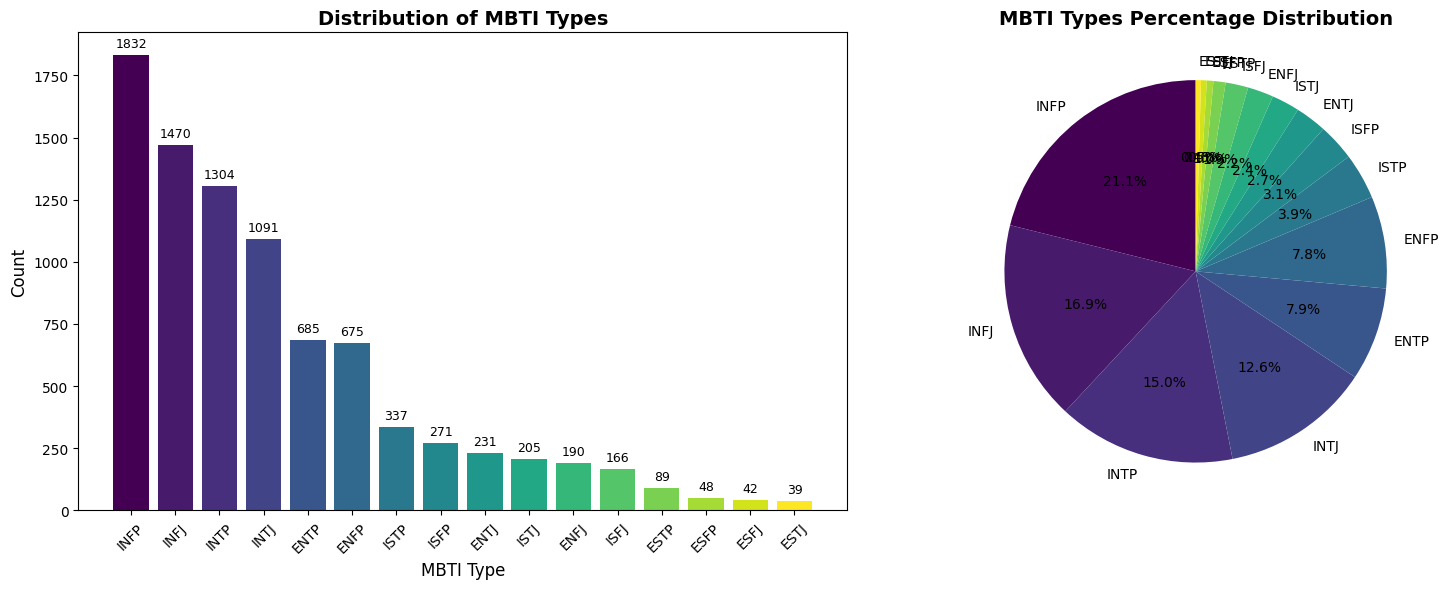


📈 Distribution Statistics:
   Most common type: INFP (1832 samples, 21.1%)
   Least common type: ESTJ (39 samples, 0.4%)
   Imbalance ratio: 46.97x


In [13]:
# ============================================
# 📊 MBTI TYPE DISTRIBUTION
# ============================================
print("=" * 60)
print("📊 MBTI TYPE DISTRIBUTION")
print("=" * 60)

# Count MBTI types
mbti_counts = df['type'].value_counts()
print(f"\n📋 MBTI Type Counts:")
print(mbti_counts)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(mbti_counts)))
bars = ax1.bar(mbti_counts.index, mbti_counts.values, color=colors)
ax1.set_xlabel('MBTI Type', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of MBTI Types', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, mbti_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             str(count), ha='center', va='bottom', fontsize=9)

# Pie chart
ax2 = axes[1]
ax2.pie(mbti_counts.values, labels=mbti_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('MBTI Types Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical summary
print(f"\n📈 Distribution Statistics:")
print(f"   Most common type: {mbti_counts.idxmax()} ({mbti_counts.max()} samples, {mbti_counts.max()/len(df)*100:.1f}%)")
print(f"   Least common type: {mbti_counts.idxmin()} ({mbti_counts.min()} samples, {mbti_counts.min()/len(df)*100:.1f}%)")
print(f"   Imbalance ratio: {mbti_counts.max()/mbti_counts.min():.2f}x")


### 2.3 Text Length Analysis


📏 TEXT LENGTH ANALYSIS

📊 Text Length Statistics:
         char_count   word_count   post_count  avg_word_length
count   8675.000000  8675.000000  8675.000000      8675.000000
mean    7234.989625  1226.241499    48.742939         5.008658
std     1607.806938   311.210544     5.475907         2.316698
min       57.000000     4.000000     1.000000         3.964231
25%     6325.000000  1046.500000    50.000000         4.669661
50%     7515.000000  1278.000000    50.000000         4.827356
75%     8429.000000  1457.000000    50.000000         5.042047
max    10090.000000  1881.000000    89.000000       141.809524


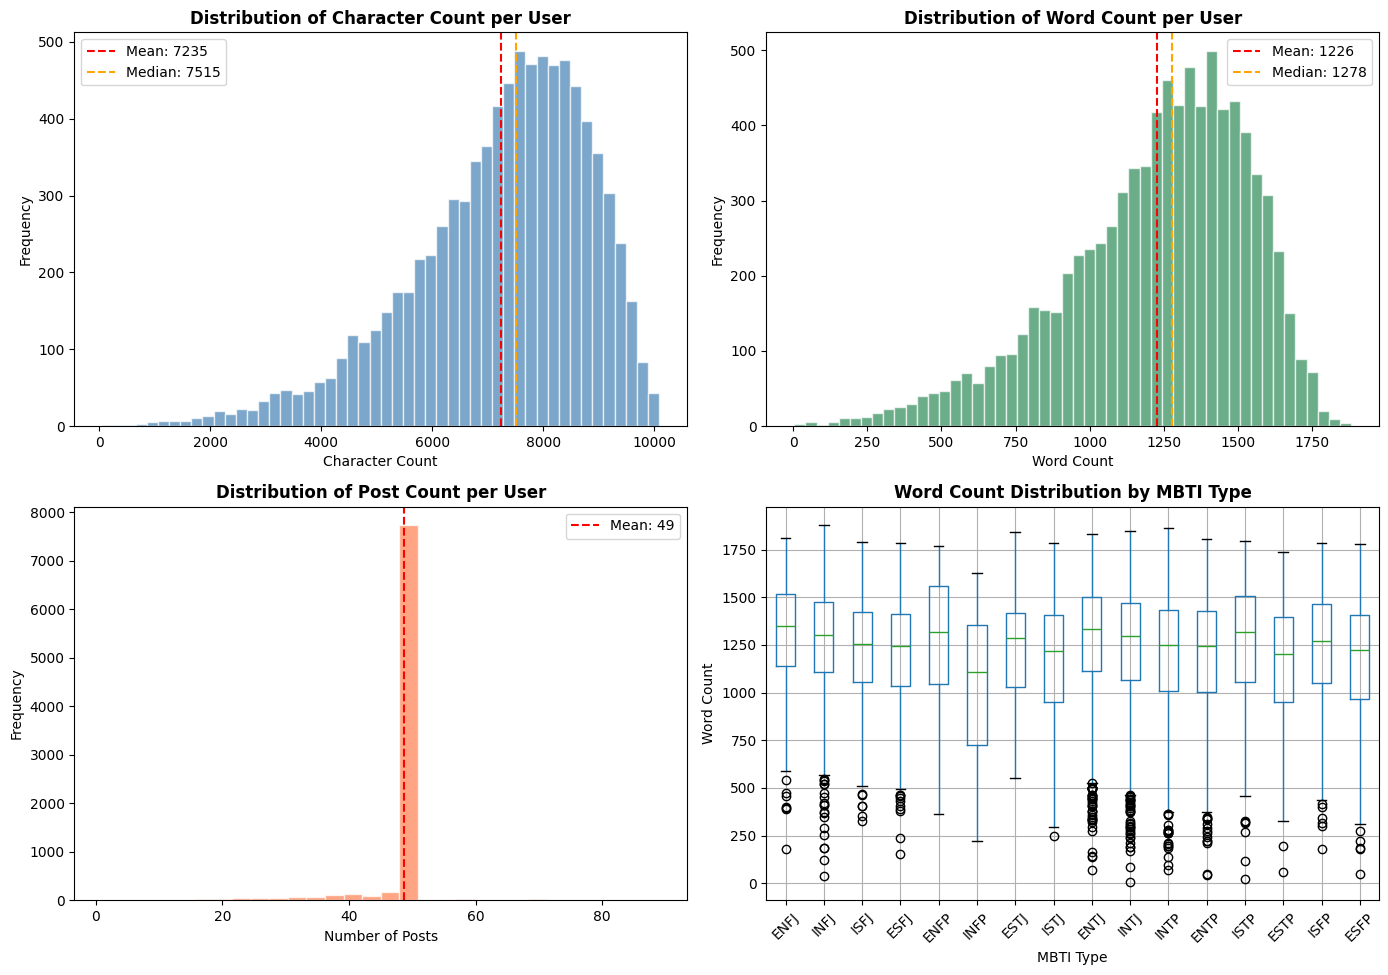


📋 Average Word Count by MBTI Type:
        mean    std  median
type                       
ESFJ  1290.5  352.0  1318.5
ENFJ  1286.6  311.1  1349.5
INFJ  1278.4  300.8  1335.5
ENFP  1260.8  299.5  1300.0
INFP  1244.6  309.0  1296.0
ISFJ  1241.3  357.3  1319.0
ESTJ  1229.5  299.4  1284.0
ENTJ  1218.1  289.9  1255.0
ISTJ  1213.2  329.3  1268.0
ENTP  1206.0  280.7  1242.0
INTP  1197.8  305.4  1246.5
INTJ  1194.6  317.8  1247.0
ISTP  1165.6  323.2  1221.0
ESTP  1162.6  323.4  1218.0
ISFP  1136.4  339.3  1200.0
ESFP  1022.1  390.5  1106.0


In [14]:
# ============================================
# 📏 TEXT LENGTH ANALYSIS
# ============================================
print("=" * 60)
print("📏 TEXT LENGTH ANALYSIS")
print("=" * 60)

# Calculate text statistics
df['char_count'] = df['posts'].apply(len)
df['word_count'] = df['posts'].apply(lambda x: len(x.split()))
df['post_count'] = df['posts'].apply(lambda x: len(x.split('|||')))
df['avg_word_length'] = df['posts'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)

print("\n📊 Text Length Statistics:")
print(df[['char_count', 'word_count', 'post_count', 'avg_word_length']].describe())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Character count distribution
ax1 = axes[0, 0]
ax1.hist(df['char_count'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(df['char_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["char_count"].mean():.0f}')
ax1.axvline(df['char_count'].median(), color='orange', linestyle='--', label=f'Median: {df["char_count"].median():.0f}')
ax1.set_xlabel('Character Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Character Count per User', fontweight='bold')
ax1.legend()

# Word count distribution
ax2 = axes[0, 1]
ax2.hist(df['word_count'], bins=50, color='seagreen', edgecolor='white', alpha=0.7)
ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
ax2.axvline(df['word_count'].median(), color='orange', linestyle='--', label=f'Median: {df["word_count"].median():.0f}')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Word Count per User', fontweight='bold')
ax2.legend()

# Post count distribution
ax3 = axes[1, 0]
ax3.hist(df['post_count'], bins=30, color='coral', edgecolor='white', alpha=0.7)
ax3.axvline(df['post_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["post_count"].mean():.0f}')
ax3.set_xlabel('Number of Posts')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Post Count per User', fontweight='bold')
ax3.legend()

# Word count by MBTI type (boxplot)
ax4 = axes[1, 1]
mbti_order = df.groupby('type')['word_count'].median().sort_values(ascending=False).index
df.boxplot(column='word_count', by='type', ax=ax4, positions=range(len(mbti_order)))
ax4.set_xticklabels(mbti_order, rotation=45)
ax4.set_xlabel('MBTI Type')
ax4.set_ylabel('Word Count')
ax4.set_title('Word Count Distribution by MBTI Type', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Summary statistics by MBTI type
print("\n📋 Average Word Count by MBTI Type:")
word_count_by_type = df.groupby('type')['word_count'].agg(['mean', 'std', 'median']).round(1)
word_count_by_type = word_count_by_type.sort_values('mean', ascending=False)
print(word_count_by_type)


### 2.4 Word Cloud Analysis


☁️ WORD CLOUD ANALYSIS


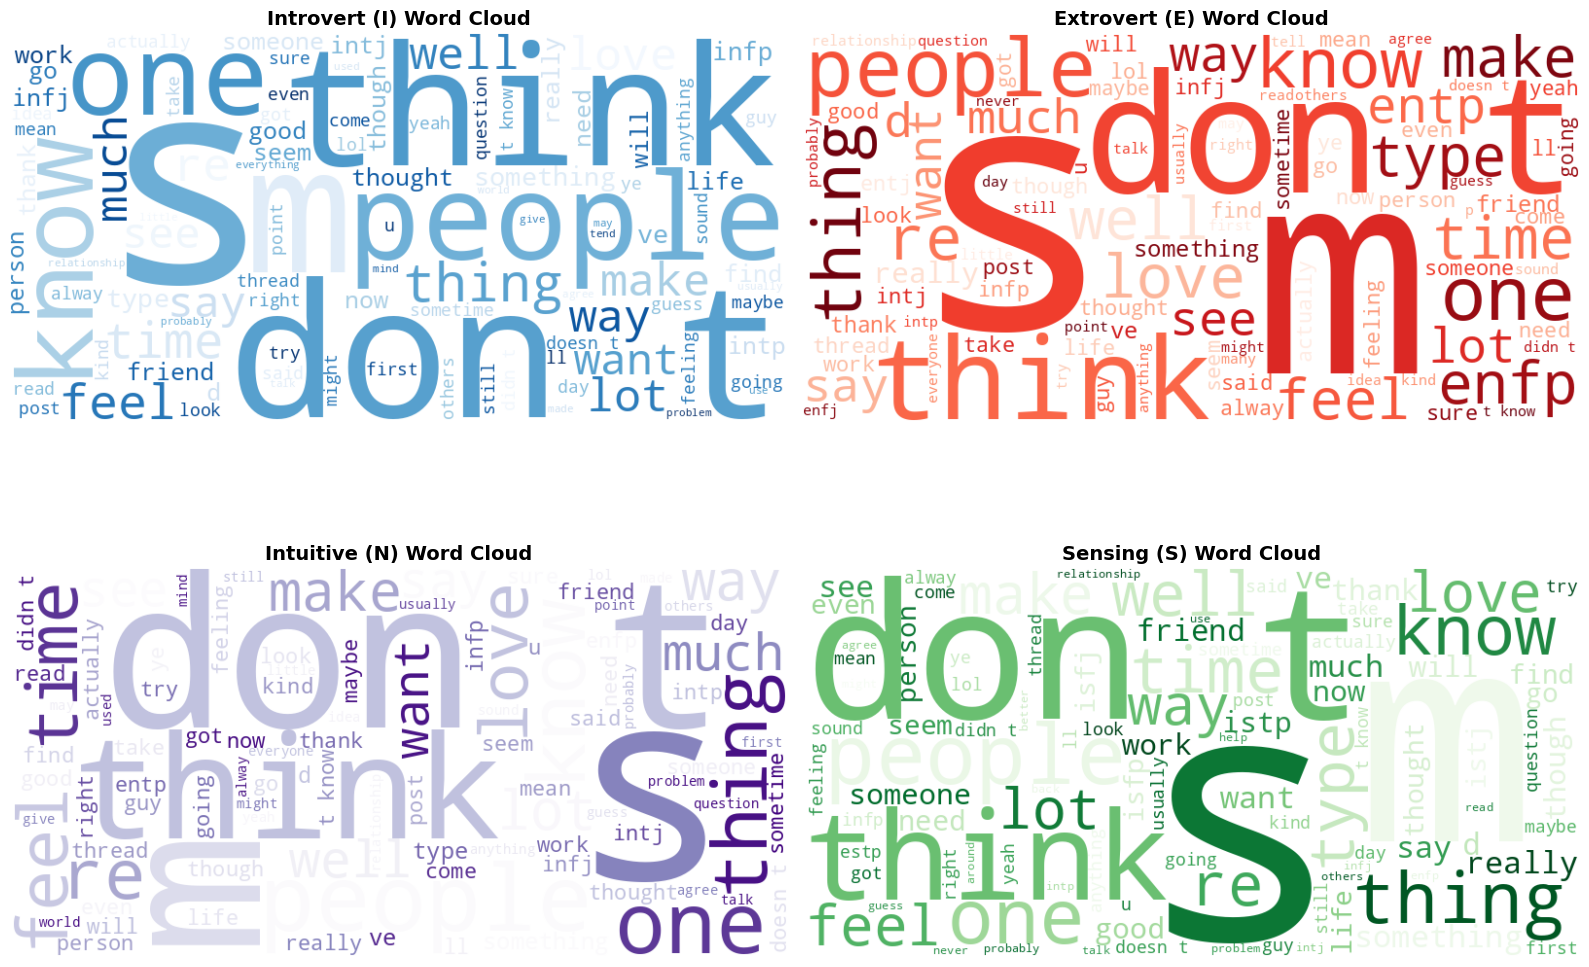

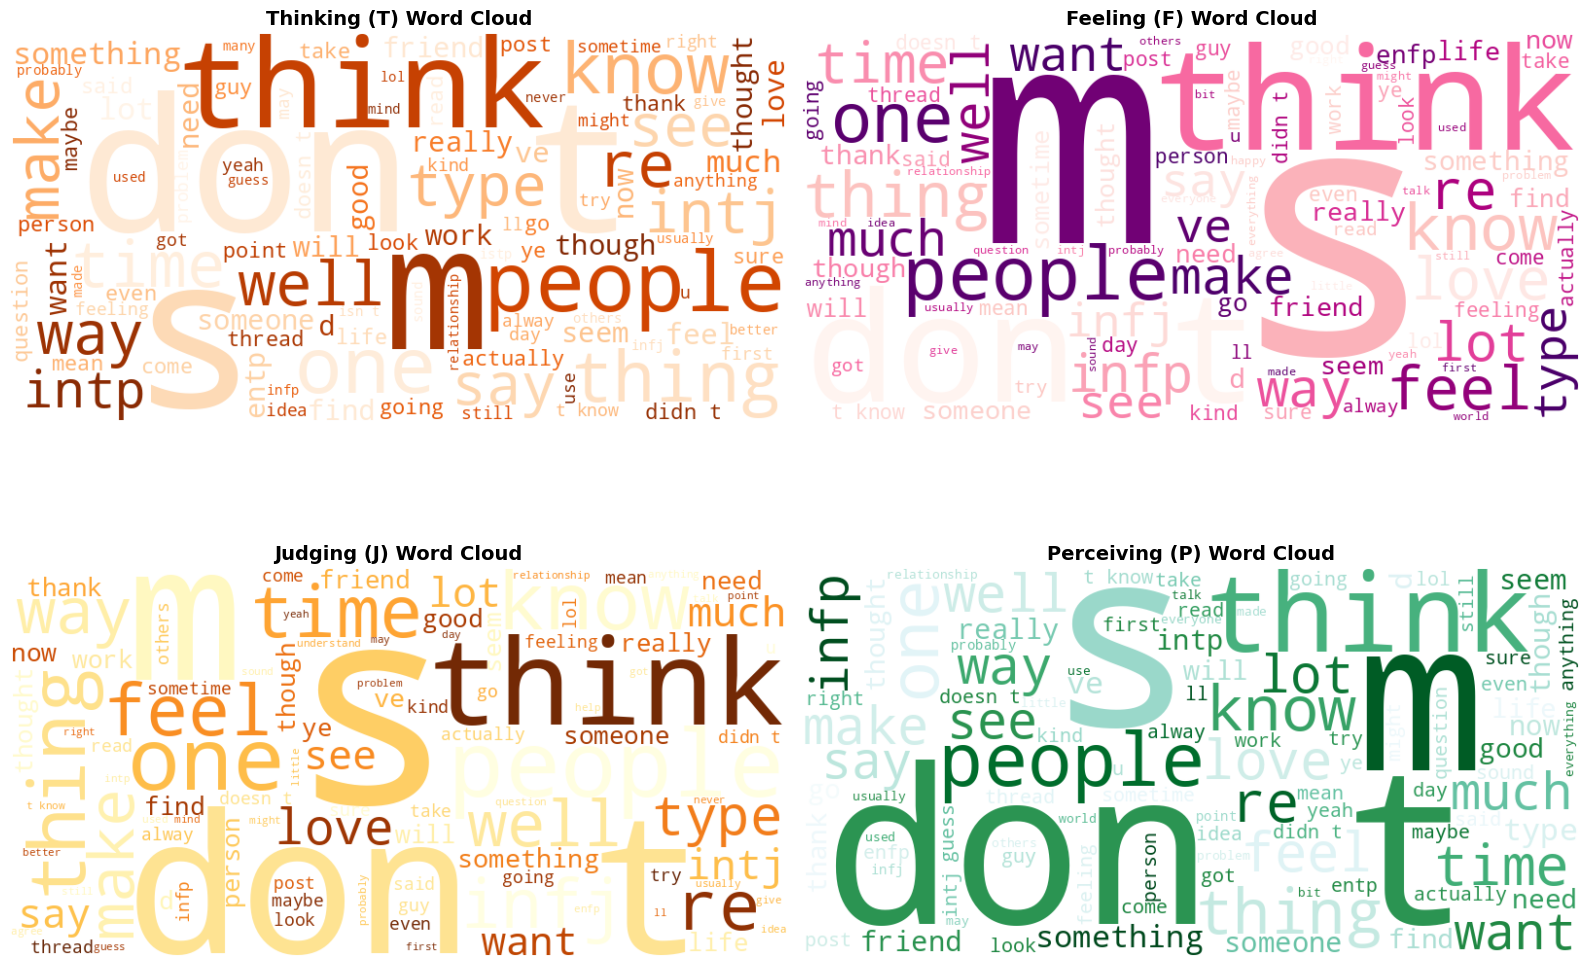

In [15]:
# ============================================
# ☁️ WORD CLOUD ANALYSIS
# ============================================
from wordcloud import WordCloud

print("=" * 60)
print("☁️ WORD CLOUD ANALYSIS")
print("=" * 60)

# Helper function for basic text cleaning (for word cloud only)
def simple_clean(text):
    text = text.replace('|||', ' ')
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
    return text

# Create word clouds for different personality dimensions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Introvert vs Extrovert
introvert_text = ' '.join(df[df['type'].str.startswith('I')]['posts'].apply(simple_clean))
extrovert_text = ' '.join(df[df['type'].str.startswith('E')]['posts'].apply(simple_clean))

# Intuitive vs Sensing
intuitive_text = ' '.join(df[df['type'].str.contains('N')]['posts'].apply(simple_clean))
sensing_text = ' '.join(df[df['type'].str.contains('S')]['posts'].apply(simple_clean))

# Thinking vs Feeling
thinking_text = ' '.join(df[df['type'].str.contains('T')]['posts'].apply(simple_clean))
feeling_text = ' '.join(df[df['type'].str.contains('F')]['posts'].apply(simple_clean))

# Judging vs Perceiving
judging_text = ' '.join(df[df['type'].str.endswith('J')]['posts'].apply(simple_clean))
perceiving_text = ' '.join(df[df['type'].str.endswith('P')]['posts'].apply(simple_clean))

# Generate word clouds
wordcloud_intro = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Blues', max_words=100).generate(introvert_text)
wordcloud_extro = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Reds', max_words=100).generate(extrovert_text)
wordcloud_intuit = WordCloud(width=800, height=400, background_color='white', 
                             colormap='Purples', max_words=100).generate(intuitive_text)
wordcloud_sense = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Greens', max_words=100).generate(sensing_text)

# Plot
axes[0, 0].imshow(wordcloud_intro, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Introvert (I) Word Cloud', fontsize=14, fontweight='bold')

axes[0, 1].imshow(wordcloud_extro, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('Extrovert (E) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 0].imshow(wordcloud_intuit, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Intuitive (N) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 1].imshow(wordcloud_sense, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Sensing (S) Word Cloud', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional word clouds for T/F and J/P
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

wordcloud_think = WordCloud(width=800, height=400, background_color='white', 
                            colormap='Oranges', max_words=100).generate(thinking_text)
wordcloud_feel = WordCloud(width=800, height=400, background_color='white', 
                           colormap='RdPu', max_words=100).generate(feeling_text)
wordcloud_judge = WordCloud(width=800, height=400, background_color='white', 
                            colormap='YlOrBr', max_words=100).generate(judging_text)
wordcloud_perc = WordCloud(width=800, height=400, background_color='white', 
                           colormap='BuGn', max_words=100).generate(perceiving_text)

axes[0, 0].imshow(wordcloud_think, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Thinking (T) Word Cloud', fontsize=14, fontweight='bold')

axes[0, 1].imshow(wordcloud_feel, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('Feeling (F) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 0].imshow(wordcloud_judge, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Judging (J) Word Cloud', fontsize=14, fontweight='bold')

axes[1, 1].imshow(wordcloud_perc, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Perceiving (P) Word Cloud', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 2.5 Word Frequency Analysis


📊 WORD FREQUENCY ANALYSIS


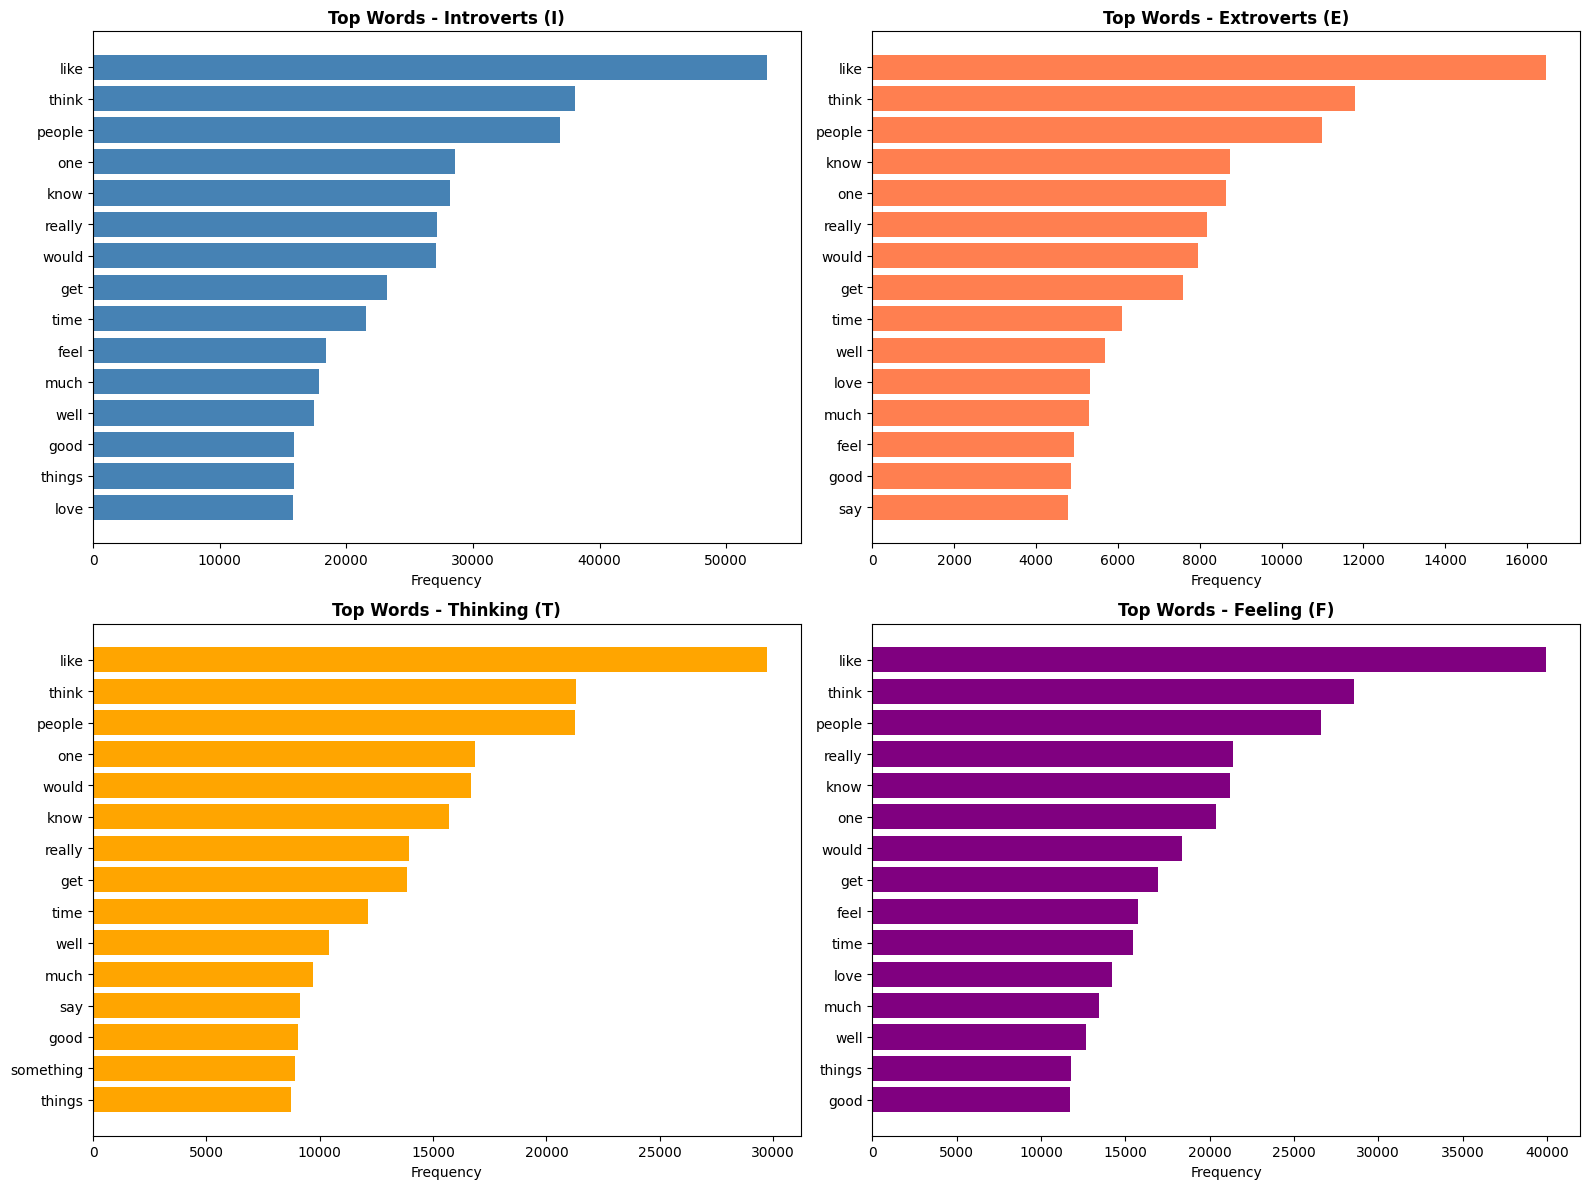


📝 Distinctive Words Analysis:
----------------------------------------

🔹 Unique to Introverts: {'things'}
🔹 Unique to Extroverts: {'say'}

🔹 Unique to Thinking: {'say', 'something'}
🔹 Unique to Feeling: {'feel', 'love'}


In [16]:
# ============================================
# 📊 WORD FREQUENCY ANALYSIS
# ============================================
from collections import Counter

print("=" * 60)
print("📊 WORD FREQUENCY ANALYSIS")
print("=" * 60)

# Get word frequencies for each dimension
def get_top_words(text, n=20):
    words = text.lower().split()
    # Remove stopwords and short words
    words = [w for w in words if w not in stop_words and len(w) > 2 and w.isalpha()]
    return Counter(words).most_common(n)

# Compare Introvert vs Extrovert
intro_words = get_top_words(introvert_text, 15)
extro_words = get_top_words(extrovert_text, 15)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Introvert top words
ax1 = axes[0, 0]
words_i, counts_i = zip(*intro_words)
ax1.barh(words_i[::-1], counts_i[::-1], color='steelblue')
ax1.set_xlabel('Frequency')
ax1.set_title('Top Words - Introverts (I)', fontweight='bold')

# Extrovert top words
ax2 = axes[0, 1]
words_e, counts_e = zip(*extro_words)
ax2.barh(words_e[::-1], counts_e[::-1], color='coral')
ax2.set_xlabel('Frequency')
ax2.set_title('Top Words - Extroverts (E)', fontweight='bold')

# Thinking vs Feeling
think_words = get_top_words(thinking_text, 15)
feel_words = get_top_words(feeling_text, 15)

ax3 = axes[1, 0]
words_t, counts_t = zip(*think_words)
ax3.barh(words_t[::-1], counts_t[::-1], color='orange')
ax3.set_xlabel('Frequency')
ax3.set_title('Top Words - Thinking (T)', fontweight='bold')

ax4 = axes[1, 1]
words_f, counts_f = zip(*feel_words)
ax4.barh(words_f[::-1], counts_f[::-1], color='purple')
ax4.set_xlabel('Frequency')
ax4.set_title('Top Words - Feeling (F)', fontweight='bold')

plt.tight_layout()
plt.show()

# Print unique words for each dimension
print("\n📝 Distinctive Words Analysis:")
print("-" * 40)

intro_set = set([w for w, _ in intro_words])
extro_set = set([w for w, _ in extro_words])
print(f"\n🔹 Unique to Introverts: {intro_set - extro_set}")
print(f"🔹 Unique to Extroverts: {extro_set - intro_set}")

think_set = set([w for w, _ in think_words])
feel_set = set([w for w, _ in feel_words])
print(f"\n🔹 Unique to Thinking: {think_set - feel_set}")
print(f"🔹 Unique to Feeling: {feel_set - think_set}")


### 2.6 Sample Posts Exploration


In [17]:
# ============================================
# 📝 SAMPLE POSTS EXPLORATION
# ============================================
print("=" * 60)
print("📝 SAMPLE POSTS EXPLORATION")
print("=" * 60)

# Show sample posts for different MBTI types
sample_types = ['INTJ', 'ENFP', 'ISTJ', 'ENTP']

for mbti_type in sample_types:
    print(f"\n{'='*60}")
    print(f"📌 Sample Post from {mbti_type}:")
    print(f"{'='*60}")
    sample = df[df['type'] == mbti_type]['posts'].iloc[0]
    # Split by ||| and show first 3 posts
    posts = sample.split('|||')[:3]
    for i, post in enumerate(posts, 1):
        print(f"\n   Post {i}: {post[:200]}..." if len(post) > 200 else f"\n   Post {i}: {post}")


📝 SAMPLE POSTS EXPLORATION

📌 Sample Post from INTJ:

   Post 1: 'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...

   Post 2: Dear ENTJ sub,   Long time no see.  Sincerely, Alpha

   Post 3: None of them. All other types hurt in deep existential ways that I want no part of.

📌 Sample Post from ENFP:

   Post 1: 'He doesn't want to go on the trip without me, so me staying behind wouldn't be an option for him. I think he really does believe that I'm the one being unreasonable. He still continues to say that...

   Post 2: I'm still completely in AWE and I'm AMAZED that he doesn't think twice about leaving one of them and how that will make them feel. He said he wants to tell them that I'm not willing to work extra for....

   Post 3: Thanks, everyone. I'm struggling with being selfish and not just going ahead and working to pay for the rest. I don't

### 2.7 Correlation Analysis & Dataset Summary


🔗 CORRELATION ANALYSIS & DATASET SUMMARY


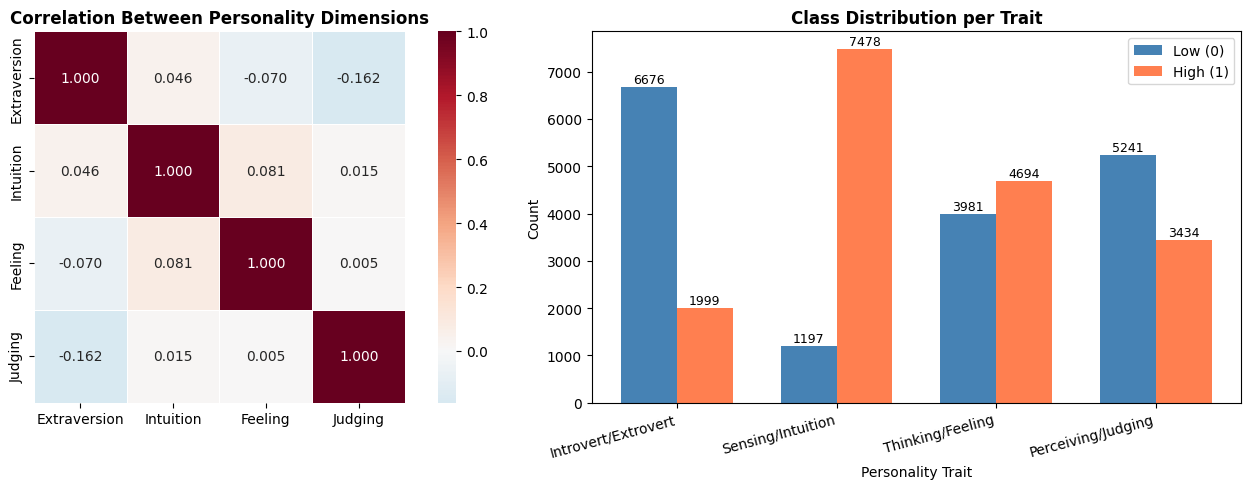


📊 DATASET SUMMARY FOR CLASSIFICATION

🎯 Extraversion:
   Low (0): 6676 (77.0%)
   High (1): 1999 (23.0%)
   Imbalance Ratio: 0.30
   ⚠️  Significant class imbalance detected!

🎯 Intuition:
   Low (0): 1197 (13.8%)
   High (1): 7478 (86.2%)
   Imbalance Ratio: 6.25
   ⚠️  Significant class imbalance detected!

🎯 Feeling:
   Low (0): 3981 (45.9%)
   High (1): 4694 (54.1%)
   Imbalance Ratio: 1.18

🎯 Judging:
   Low (0): 5241 (60.4%)
   High (1): 3434 (39.6%)
   Imbalance Ratio: 0.66


In [18]:
# ============================================
# 🔗 CORRELATION ANALYSIS & DATASET SUMMARY
# ============================================
print("=" * 60)
print("🔗 CORRELATION ANALYSIS & DATASET SUMMARY")
print("=" * 60)

# First, map MBTI to binary traits for correlation analysis
df_temp = df.copy()
df_temp['E_I'] = df_temp['type'].apply(lambda x: 1 if 'E' in x else 0)  # 1=Extrovert
df_temp['N_S'] = df_temp['type'].apply(lambda x: 1 if 'N' in x else 0)  # 1=Intuitive
df_temp['F_T'] = df_temp['type'].apply(lambda x: 1 if 'F' in x else 0)  # 1=Feeling
df_temp['J_P'] = df_temp['type'].apply(lambda x: 1 if 'J' in x else 0)  # 1=Judging

# Correlation matrix for personality dimensions
trait_cols = ['E_I', 'N_S', 'F_T', 'J_P']
trait_names = ['Extraversion', 'Intuition', 'Feeling', 'Judging']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
ax1 = axes[0]
corr_matrix = df_temp[trait_cols].corr()
corr_matrix.index = trait_names
corr_matrix.columns = trait_names
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax1, 
            fmt='.3f', square=True, linewidths=0.5)
ax1.set_title('Correlation Between Personality Dimensions', fontsize=12, fontweight='bold')

# Class distribution
ax2 = axes[1]
class_dist = pd.DataFrame({
    'Trait': trait_names * 2,
    'Class': ['Low'] * 4 + ['High'] * 4,
    'Count': [
        (df_temp['E_I'] == 0).sum(), (df_temp['N_S'] == 0).sum(), 
        (df_temp['F_T'] == 0).sum(), (df_temp['J_P'] == 0).sum(),
        (df_temp['E_I'] == 1).sum(), (df_temp['N_S'] == 1).sum(), 
        (df_temp['F_T'] == 1).sum(), (df_temp['J_P'] == 1).sum()
    ]
})

x = np.arange(len(trait_names))
width = 0.35
low_counts = [(df_temp[col] == 0).sum() for col in trait_cols]
high_counts = [(df_temp[col] == 1).sum() for col in trait_cols]

bars1 = ax2.bar(x - width/2, low_counts, width, label='Low (0)', color='steelblue')
bars2 = ax2.bar(x + width/2, high_counts, width, label='High (1)', color='coral')

ax2.set_xlabel('Personality Trait')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution per Trait', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Introvert/Extrovert', 'Sensing/Intuition', 'Thinking/Feeling', 'Perceiving/Judging'], 
                    rotation=15, ha='right')
ax2.legend()

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n📊 DATASET SUMMARY FOR CLASSIFICATION")
print("=" * 60)

for col, name in zip(trait_cols, trait_names):
    low = (df_temp[col] == 0).sum()
    high = (df_temp[col] == 1).sum()
    ratio = high / low if low > 0 else float('inf')
    print(f"\n🎯 {name}:")
    print(f"   Low (0): {low} ({low/len(df_temp)*100:.1f}%)")
    print(f"   High (1): {high} ({high/len(df_temp)*100:.1f}%)")
    print(f"   Imbalance Ratio: {ratio:.2f}")
    if ratio < 0.5 or ratio > 2:
        print(f"   ⚠️  Significant class imbalance detected!")


---
## 3. 📊 Traditional ML Approach (TF-IDF + Classical Models)


In [19]:
# ============================================
# 🔤 TF-IDF VECTORIZATION
# ============================================
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.95)
X_tfidf = tfidf.fit_transform(df['clean_posts'])
print(f"✅ TF-IDF shape: {X_tfidf.shape}")


Creating TF-IDF features...
✅ TF-IDF shape: (8675, 10000)


In [20]:
# ============================================
# 🤖 TRAIN TRADITIONAL ML MODELS
# ============================================
from sklearn.naive_bayes import MultinomialNB

def train_ml_models(X, y, trait_name):
    """Train and evaluate multiple ML models with SMOTE"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    
    # Calculate class weight for XGBoost
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
        'Linear SVM': LinearSVC(class_weight='balanced', random_state=RANDOM_STATE, max_iter=2000),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
        'Naive Bayes': MultinomialNB(alpha=1.0),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss',
                                  scale_pos_weight=scale_pos_weight, n_jobs=-1)
    }
    
    results = []
    all_models = {}
    best_model = None
    best_f1 = 0
    
    for name, model in models.items():
        # Naive Bayes needs non-negative data (use original, not SMOTE resampled for NB)
        if name == 'Naive Bayes':
            model.fit(X_train, y_train)  # NB doesn't work well with SMOTE
        else:
            model.fit(X_train_sm, y_train_sm)
        
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({'Model': name, 'Accuracy': acc, 'F1': f1})
        all_models[name] = model
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = (name, model)
    
    return pd.DataFrame(results), best_model, all_models, y_test, y_pred

# Train for all traits
print("🚀 Training Traditional ML Models (5 models per trait)...")
print("="*60)

ml_results = {}
ml_all_models = {}

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait}:")
    results_df, best, all_models, y_test, y_pred = train_ml_models(X_tfidf, df[trait], trait)
    ml_results[trait] = {'results': results_df, 'best': best}
    ml_all_models[trait] = all_models
    print(results_df.sort_values('F1', ascending=False).to_string(index=False))
    print(f"   🏆 Best: {best[0]} (F1: {results_df[results_df['Model']==best[0]]['F1'].values[0]:.4f})")


🚀 Training Traditional ML Models (5 models per trait)...

🎯 Extraversion:
              Model  Accuracy       F1
Logistic Regression  0.755043 0.759286
         Linear SVM  0.759078 0.756885
            XGBoost  0.731412 0.721657
      Random Forest  0.769452 0.678535
        Naive Bayes  0.769452 0.669198
   🏆 Best: Logistic Regression (F1: 0.7593)

🎯 Openness:
              Model  Accuracy       F1
Logistic Regression  0.831700 0.835562
         Linear SVM  0.831124 0.828810
            XGBoost  0.816715 0.804917
        Naive Bayes  0.862248 0.798467
      Random Forest  0.859942 0.797319
   🏆 Best: Logistic Regression (F1: 0.8356)

🎯 Agreeableness:
              Model  Accuracy       F1
Logistic Regression  0.778098 0.778456
         Linear SVM  0.755043 0.755313
        Naive Bayes  0.757925 0.754723
            XGBoost  0.729107 0.729347
      Random Forest  0.722190 0.721852
   🏆 Best: Logistic Regression (F1: 0.7785)

🎯 Conscientiousness:
              Model  Accuracy       F1


### 3.1 Confusion Matrix Analysis


📊 CONFUSION MATRIX ANALYSIS


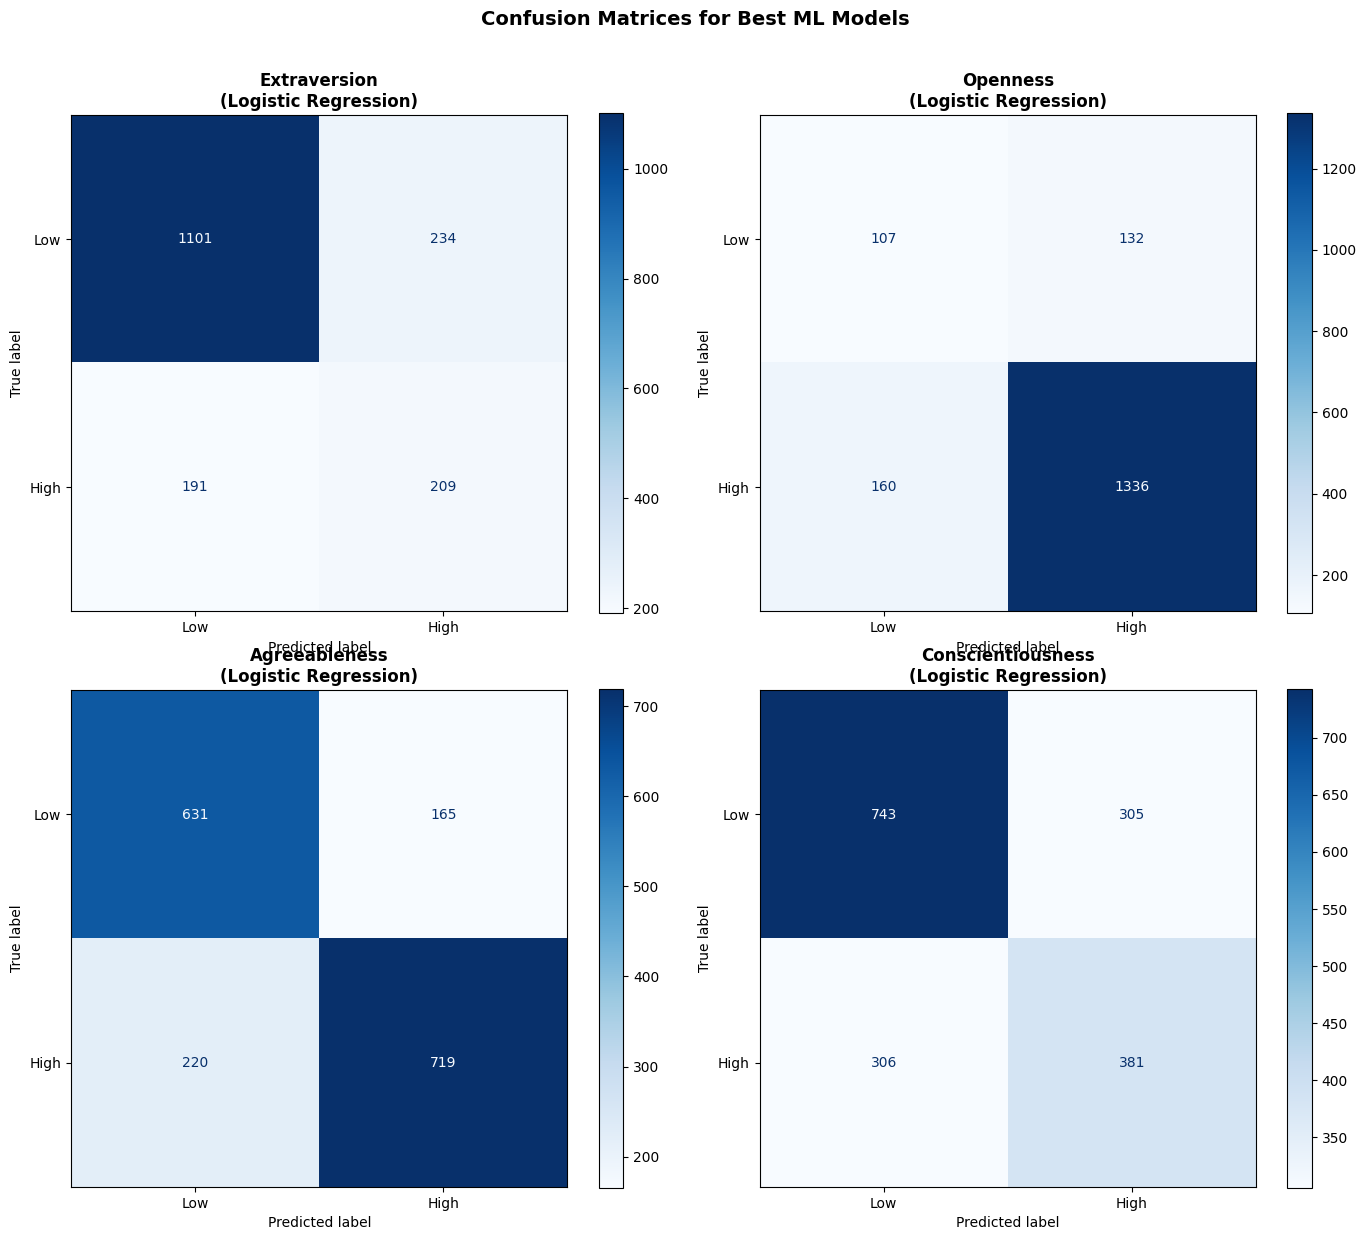


📋 DETAILED CLASSIFICATION REPORTS

🎯 Extraversion (Logistic Regression):
----------------------------------------
              precision    recall  f1-score   support

         Low       0.85      0.82      0.84      1335
        High       0.47      0.52      0.50       400

    accuracy                           0.76      1735
   macro avg       0.66      0.67      0.67      1735
weighted avg       0.76      0.76      0.76      1735


🎯 Openness (Logistic Regression):
----------------------------------------
              precision    recall  f1-score   support

         Low       0.40      0.45      0.42       239
        High       0.91      0.89      0.90      1496

    accuracy                           0.83      1735
   macro avg       0.66      0.67      0.66      1735
weighted avg       0.84      0.83      0.84      1735


🎯 Agreeableness (Logistic Regression):
----------------------------------------
              precision    recall  f1-score   support

         Low       

In [21]:
# ============================================
# 📊 CONFUSION MATRIX ANALYSIS
# ============================================
from sklearn.metrics import ConfusionMatrixDisplay

print("=" * 60)
print("📊 CONFUSION MATRIX ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx // 2, idx % 2]
    
    # Get the best model for this trait
    best_model_name, best_model = ml_results[trait]['best']
    
    # Make predictions on test set
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, df[trait], test_size=0.2, random_state=RANDOM_STATE, stratify=df[trait]
    )
    
    y_pred = best_model.predict(X_test)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'High'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{trait}\n({best_model_name})', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices for Best ML Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print classification reports
print("\n📋 DETAILED CLASSIFICATION REPORTS")
print("=" * 60)

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait} ({ml_results[trait]['best'][0]}):")
    print("-" * 40)
    
    best_model = ml_results[trait]['best'][1]
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, df[trait], test_size=0.2, random_state=RANDOM_STATE, stratify=df[trait]
    )
    y_pred = best_model.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=['Low', 'High']))


### 3.2 Feature Importance Analysis


🔍 FEATURE IMPORTANCE ANALYSIS


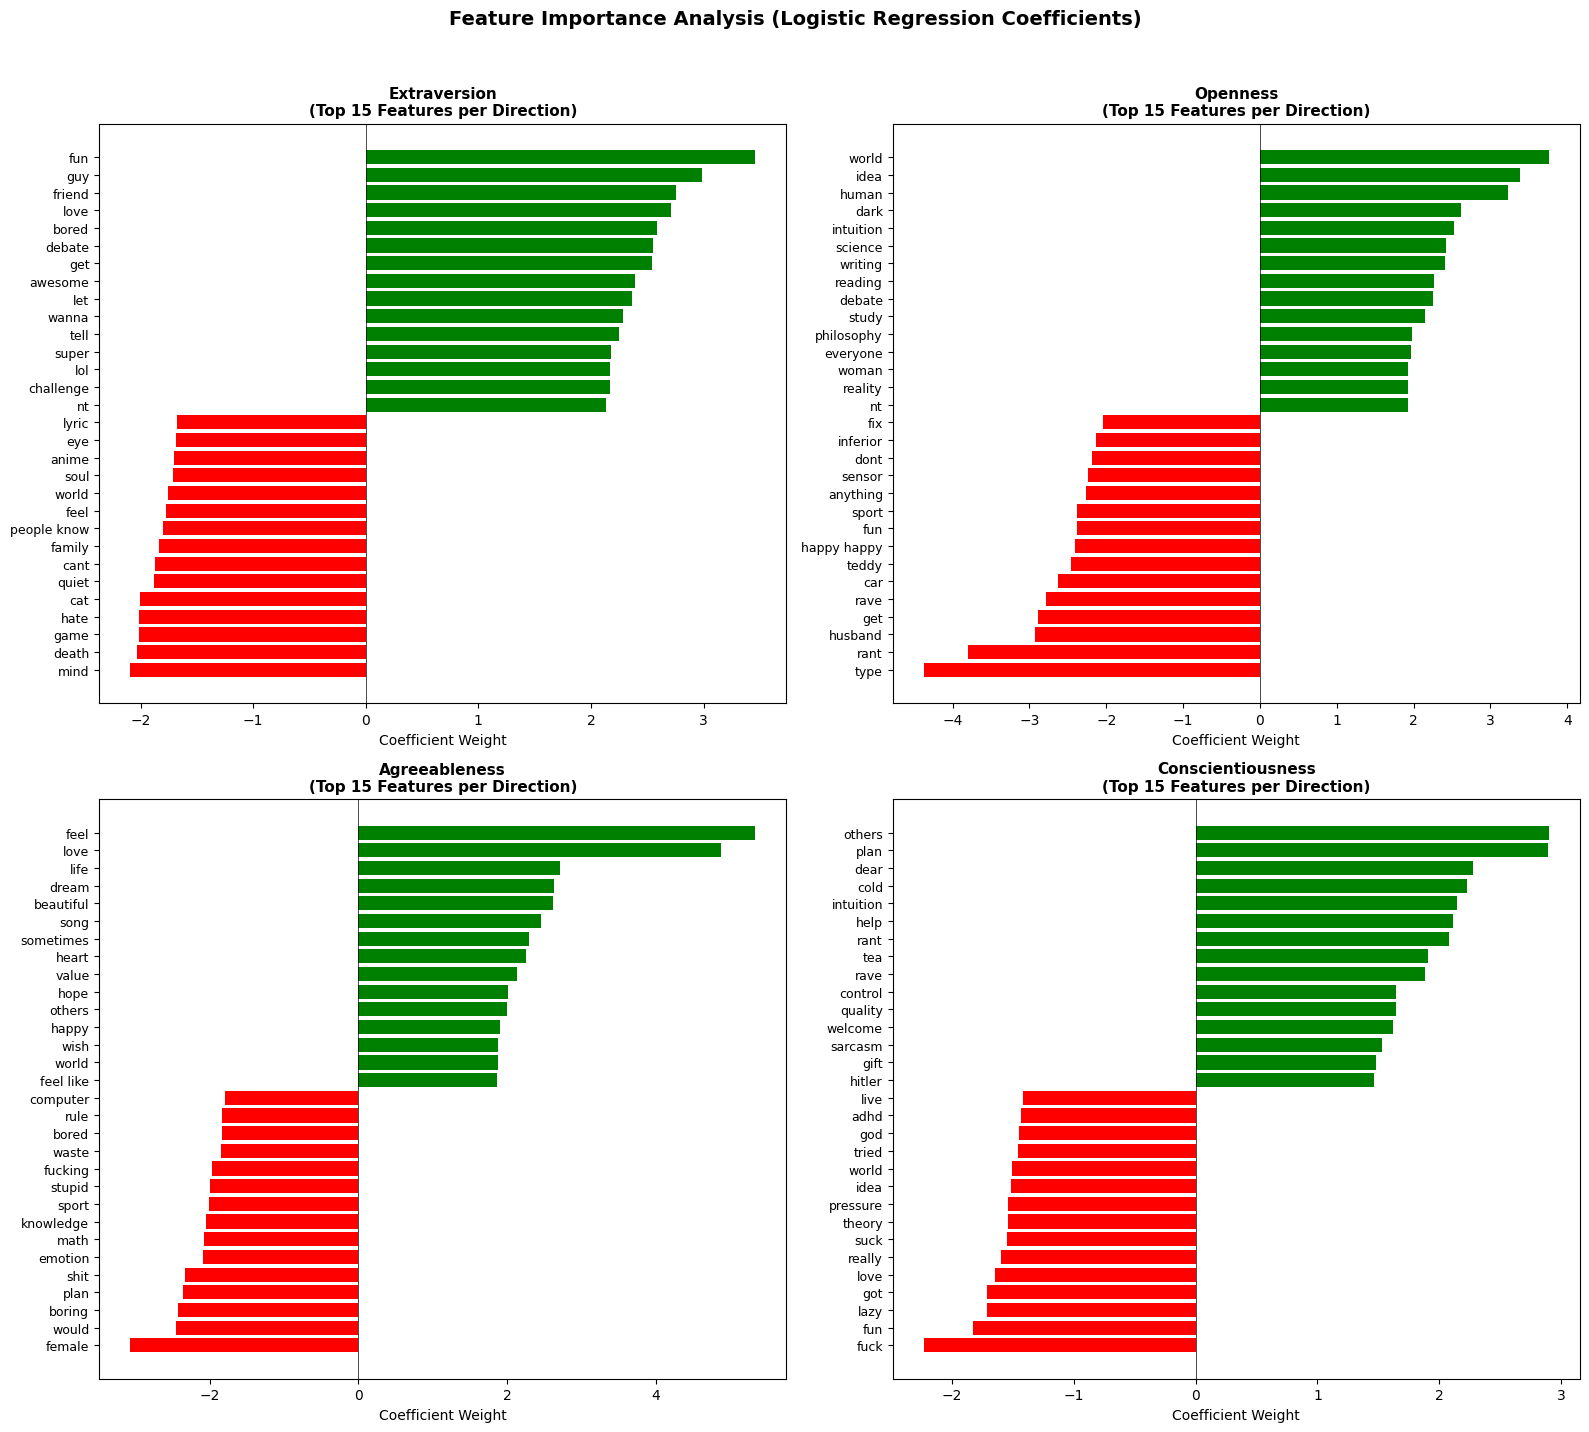


📋 TOP 10 MOST IMPORTANT FEATURES PER TRAIT

🎯 Extraversion:
----------------------------------------
   📈 Features indicating HIGH:
      fun: 3.4587
      guy: 2.9876
      friend: 2.7532
      love: 2.7073
      bored: 2.5909
      debate: 2.5536
      get: 2.5456
      awesome: 2.3915
      let: 2.3687
      wanna: 2.2871
   📉 Features indicating LOW:
      mind: -2.0906
      death: -2.0343
      game: -2.0161
      hate: -2.0128
      cat: -2.0089
      quiet: -1.8833
      cant: -1.8687
      family: -1.8364
      people know: -1.7986
      feel: -1.7738

🎯 Openness:
----------------------------------------
   📈 Features indicating HIGH:
      world: 3.7597
      idea: 3.3910
      human: 3.2274
      dark: 2.6223
      intuition: 2.5308
      science: 2.4200
      writing: 2.4031
      reading: 2.2666
      debate: 2.2573
      study: 2.1522
   📉 Features indicating LOW:
      type: -4.3743
      rant: -3.7970
      husband: -2.9276
      get: -2.8856
      rave: -2.7889
      

In [22]:
# ============================================
# 🔍 FEATURE IMPORTANCE ANALYSIS
# ============================================
print("=" * 60)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature names from TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx // 2, idx % 2]
    
    # Get the best model
    best_model_name, best_model = ml_results[trait]['best']
    
    # Get feature importance/coefficients
    if hasattr(best_model, 'coef_'):
        # For Logistic Regression, SVM
        importance = best_model.coef_[0]
    elif hasattr(best_model, 'feature_importances_'):
        # For Random Forest, XGBoost
        importance = best_model.feature_importances_
    else:
        continue
    
    # Get top positive and negative features
    n_features = 15
    top_positive_idx = np.argsort(importance)[-n_features:]
    top_negative_idx = np.argsort(importance)[:n_features]
    
    # Combine and sort
    top_idx = np.concatenate([top_negative_idx, top_positive_idx])
    top_features = feature_names[top_idx]
    top_importance = importance[top_idx]
    
    # Plot
    colors = ['red' if x < 0 else 'green' for x in top_importance]
    ax.barh(range(len(top_features)), top_importance, color=colors)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features, fontsize=9)
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlabel('Coefficient Weight')
    ax.set_title(f'{trait}\n(Top {n_features} Features per Direction)', fontsize=11, fontweight='bold')

plt.suptitle('Feature Importance Analysis (Logistic Regression Coefficients)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print top features for each trait
print("\n📋 TOP 10 MOST IMPORTANT FEATURES PER TRAIT")
print("=" * 60)

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait}:")
    print("-" * 40)
    
    best_model = ml_results[trait]['best'][1]
    
    if hasattr(best_model, 'coef_'):
        importance = best_model.coef_[0]
        
        # Top features for HIGH
        top_high_idx = np.argsort(importance)[-10:][::-1]
        print("   📈 Features indicating HIGH:")
        for i in top_high_idx:
            print(f"      {feature_names[i]}: {importance[i]:.4f}")
        
        # Top features for LOW
        top_low_idx = np.argsort(importance)[:10]
        print("   📉 Features indicating LOW:")
        for i in top_low_idx:
            print(f"      {feature_names[i]}: {importance[i]:.4f}")


### 3.3 Cross-Validation Analysis


🔄 CROSS-VALIDATION ANALYSIS (5-Fold)

🎯 Extraversion:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.7376 0.7477 0.7399 0.7499 0.7534]
   Mean F1: 0.7457 (+/- 0.0120)

🎯 Openness:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.8213 0.8187 0.8191 0.8177 0.8115]
   Mean F1: 0.8176 (+/- 0.0065)

🎯 Agreeableness:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.8221 0.7877 0.7977 0.7836 0.794 ]
   Mean F1: 0.7970 (+/- 0.0269)

🎯 Conscientiousness:
----------------------------------------
   Model: Logistic Regression
   CV F1 Scores: [0.6643 0.6431 0.669  0.6337 0.6406]
   Mean F1: 0.6501 (+/- 0.0278)


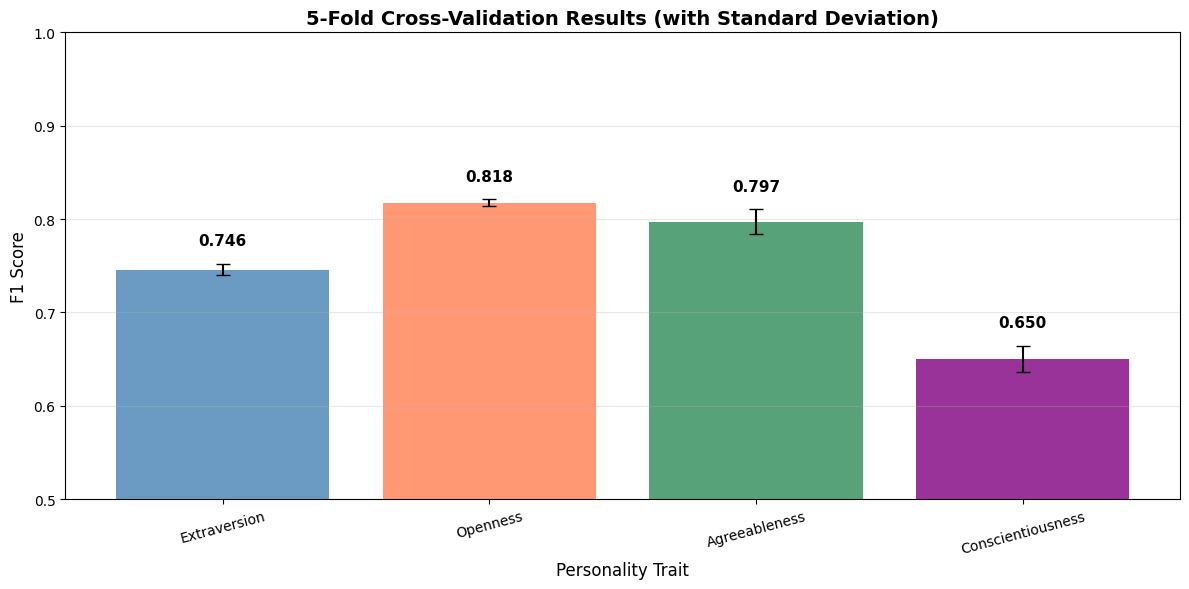


📊 CROSS-VALIDATION SUMMARY
            Trait  Mean F1  Std Dev  95% CI Lower  95% CI Upper
     Extraversion   0.7457   0.0060        0.7337        0.7577
         Openness   0.8176   0.0033        0.8111        0.8242
    Agreeableness   0.7970   0.0135        0.7701        0.8239
Conscientiousness   0.6501   0.0139        0.6224        0.6779


In [23]:
# ============================================
# 🔄 CROSS-VALIDATION ANALYSIS
# ============================================
from sklearn.model_selection import cross_val_score

print("=" * 60)
print("🔄 CROSS-VALIDATION ANALYSIS (5-Fold)")
print("=" * 60)

cv_results = {}

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait}:")
    print("-" * 40)
    
    best_model_name, best_model = ml_results[trait]['best']
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(best_model, X_tfidf, df[trait], cv=5, scoring='f1_weighted')
    
    cv_results[trait] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"   Model: {best_model_name}")
    print(f"   CV F1 Scores: {cv_scores.round(4)}")
    print(f"   Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

traits = list(cv_results.keys())
means = [cv_results[t]['mean'] for t in traits]
stds = [cv_results[t]['std'] for t in traits]

x = np.arange(len(traits))
bars = ax.bar(x, means, yerr=stds, capsize=5, color=['steelblue', 'coral', 'seagreen', 'purple'], alpha=0.8)

ax.set_xlabel('Personality Trait', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results (with Standard Deviation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(traits, rotation=15)
ax.set_ylim(0.5, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02, 
            f'{mean:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print("\n📊 CROSS-VALIDATION SUMMARY")
print("=" * 60)
cv_summary = pd.DataFrame({
    'Trait': traits,
    'Mean F1': means,
    'Std Dev': stds,
    '95% CI Lower': [m - 2*s for m, s in zip(means, stds)],
    '95% CI Upper': [m + 2*s for m, s in zip(means, stds)]
}).round(4)
print(cv_summary.to_string(index=False))


### 3.4 Error Analysis


In [24]:
# ============================================
# ❌ ERROR ANALYSIS
# ============================================
print("=" * 60)
print("❌ ERROR ANALYSIS")
print("=" * 60)

# Analyze misclassified samples for Extraversion (most intuitive trait)
trait = 'Extraversion'
print(f"\n🔍 Analyzing misclassified samples for: {trait}")
print("-" * 50)

# Split and predict
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df[trait], test_size=0.2, random_state=RANDOM_STATE, stratify=df[trait]
)

# Get test indices
test_indices = y_test.index.tolist()

best_model = ml_results[trait]['best'][1]
y_pred = best_model.predict(X_test)

# Find misclassified samples
misclassified_mask = y_pred != y_test.values
misclassified_indices = [test_indices[i] for i in range(len(test_indices)) if misclassified_mask[i]]

print(f"\n📊 Misclassification Statistics:")
print(f"   Total test samples: {len(y_test)}")
print(f"   Misclassified: {sum(misclassified_mask)} ({sum(misclassified_mask)/len(y_test)*100:.1f}%)")
print(f"   Correctly classified: {len(y_test) - sum(misclassified_mask)}")

# Analyze false positives and false negatives
false_positives = sum((y_pred == 1) & (y_test.values == 0))
false_negatives = sum((y_pred == 0) & (y_test.values == 1))
print(f"\n   False Positives (Predicted High, Actual Low): {false_positives}")
print(f"   False Negatives (Predicted Low, Actual High): {false_negatives}")

# Show sample misclassified texts
print("\n📝 Sample Misclassified Texts:")
print("-" * 50)

# False Negatives (Extroverts predicted as Introverts)
fn_indices = [test_indices[i] for i in range(len(test_indices)) 
              if (y_pred[i] == 0) and (y_test.values[i] == 1)]

if fn_indices:
    print("\n🔴 False Negatives (Extroverts predicted as Introverts):")
    for i, idx in enumerate(fn_indices[:2]):
        print(f"\n   Sample {i+1}:")
        text = df.loc[idx, 'posts']
        posts = text.split('|||')[:2]
        for j, post in enumerate(posts):
            truncated = post[:150] + "..." if len(post) > 150 else post
            print(f"      Post {j+1}: {truncated}")

# False Positives (Introverts predicted as Extroverts)
fp_indices = [test_indices[i] for i in range(len(test_indices)) 
              if (y_pred[i] == 1) and (y_test.values[i] == 0)]

if fp_indices:
    print("\n🔵 False Positives (Introverts predicted as Extroverts):")
    for i, idx in enumerate(fp_indices[:2]):
        print(f"\n   Sample {i+1}:")
        text = df.loc[idx, 'posts']
        posts = text.split('|||')[:2]
        for j, post in enumerate(posts):
            truncated = post[:150] + "..." if len(post) > 150 else post
            print(f"      Post {j+1}: {truncated}")

# Error rate by text length
print("\n📊 Error Rate Analysis by Text Length:")
print("-" * 50)

test_df = df.loc[test_indices].copy()
test_df['predicted'] = y_pred
test_df['correct'] = (y_pred == y_test.values)

# Bin by word count
test_df['length_bin'] = pd.cut(test_df['word_count'], bins=[0, 500, 1000, 1500, float('inf')], 
                                labels=['Short (<500)', 'Medium (500-1000)', 'Long (1000-1500)', 'Very Long (>1500)'])

length_accuracy = test_df.groupby('length_bin')['correct'].mean()
print("\n   Accuracy by Text Length:")
for length, acc in length_accuracy.items():
    print(f"      {length}: {acc:.2%}")


❌ ERROR ANALYSIS

🔍 Analyzing misclassified samples for: Extraversion
--------------------------------------------------

📊 Misclassification Statistics:
   Total test samples: 1735
   Misclassified: 425 (24.5%)
   Correctly classified: 1310

   False Positives (Predicted High, Actual Low): 234
   False Negatives (Predicted Low, Actual High): 191

📝 Sample Misclassified Texts:
--------------------------------------------------

🔴 False Negatives (Extroverts predicted as Introverts):

   Sample 1:
      Post 1: Peeeace.  And maybe a genie to grant me three wishes. Hey, if any of you guys find an old lamp, can I has it?
      Post 2: When's the last time you checked up on the kids, ENTJ?

   Sample 2:
      Post 1: 'Oh I have read 1984, it is a very good book. And continued thanks, I currently am hooked on the sequel to 1632 by Eric Flint I would strongly recomme...
      Post 2: That looks very good and I will pick it up sometime in the future. Maybe next week, have spring break and lot

---
## 5. 📈 Results Comparison


📊 COMPREHENSIVE MODEL COMPARISON - ALL MODELS

────────────────────────────────────────────────────────────────────────────────
📋 1. TRADITIONAL ML MODELS - DETAILED RESULTS
────────────────────────────────────────────────────────────────────────────────

🔢 F1 Scores by Model and Trait:
Trait                Agreeableness  Conscientiousness  Extraversion  Openness
Model                                                                        
Linear SVM                  0.7553             0.6310        0.7569    0.8288
Logistic Regression         0.7785             0.6478        0.7593    0.8356
Naive Bayes                 0.7547             0.5185        0.6692    0.7985
Random Forest               0.7219             0.5655        0.6785    0.7973
XGBoost                     0.7293             0.6049        0.7217    0.8049

📈 Average F1 Score per Model:
   Logistic Regression: 0.7553
   Linear SVM: 0.7430
   XGBoost: 0.7152
   Random Forest: 0.6908
   Naive Bayes: 0.6852

──────────────

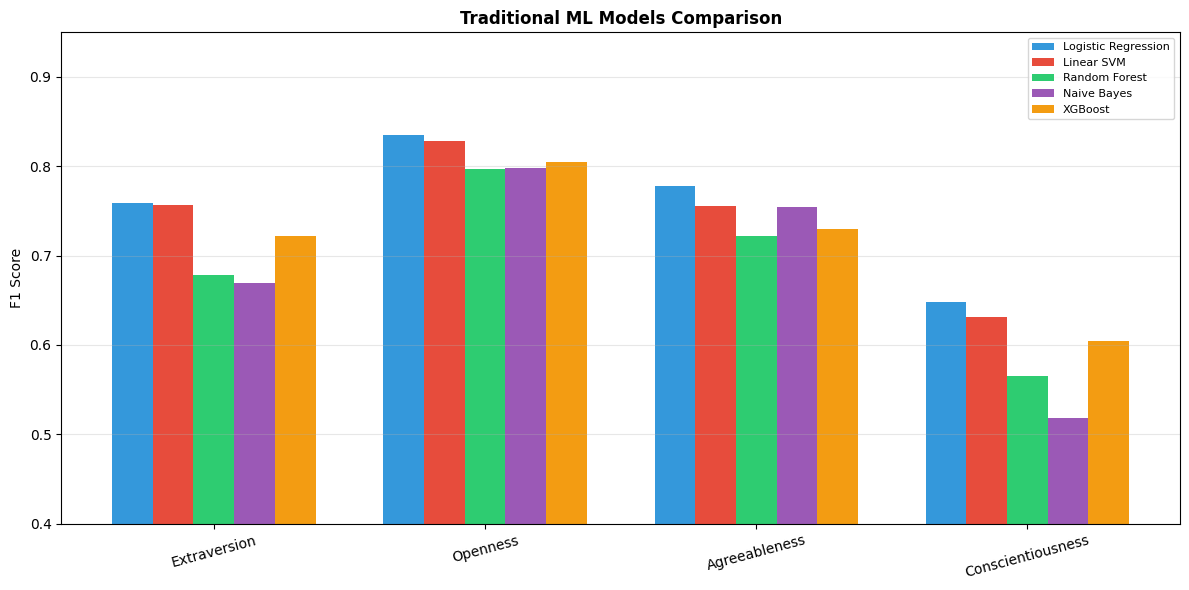


────────────────────────────────────────────────────────────────────────────────
📈 4. SUMMARY STATISTICS
────────────────────────────────────────────────────────────────────────────────

   Total models trained: 5 ML models
   Total traits: 4
   Best overall ML model: Logistic Regression (avg F1: 0.7553)


In [25]:
# ============================================
# 📊 COMPREHENSIVE MODEL COMPARISON
# ============================================
print("="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON - ALL MODELS")
print("="*80)

# 1. ML Models Comparison Table (All 5 models x 4 traits)
print("\n" + "─"*80)
print("📋 1. TRADITIONAL ML MODELS - DETAILED RESULTS")
print("─"*80)

all_ml_data = []
for trait in TARGET_TRAITS:
    for _, row in ml_results[trait]['results'].iterrows():
        all_ml_data.append({
            'Trait': trait,
            'Model': row['Model'],
            'Accuracy': row['Accuracy'],
            'F1 Score': row['F1']
        })

ml_comparison_df = pd.DataFrame(all_ml_data)

# Pivot table for better visualization
ml_pivot = ml_comparison_df.pivot(index='Model', columns='Trait', values='F1 Score')
print("\n🔢 F1 Scores by Model and Trait:")
print(ml_pivot.round(4).to_string())

# Average F1 per model
print("\n📈 Average F1 Score per Model:")
avg_f1 = ml_comparison_df.groupby('Model')['F1 Score'].mean().sort_values(ascending=False)
for model, f1 in avg_f1.items():
    print(f"   {model}: {f1:.4f}")

# 2. Best ML model per trait
print("\n" + "─"*80)
print("🏆 2. BEST ML MODEL PER TRAIT")
print("─"*80)
for trait in TARGET_TRAITS:
    best = ml_results[trait]['results'].sort_values('F1', ascending=False).iloc[0]
    print(f"   {trait}: {best['Model']} (F1: {best['F1']:.4f})")

# 3. Visualization
print("\n" + "─"*80)
print("📊 3. VISUALIZATION")
print("─"*80)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Plot: All ML models comparison
models_list = ['Logistic Regression', 'Linear SVM', 'Random Forest', 'Naive Bayes', 'XGBoost']
x = np.arange(len(TARGET_TRAITS))
width = 0.15
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

for i, model in enumerate(models_list):
    scores = [ml_results[t]['results'][ml_results[t]['results']['Model']==model]['F1'].values[0] 
              for t in TARGET_TRAITS]
    ax1.bar(x + i*width, scores, width, label=model, color=colors[i])

ax1.set_ylabel('F1 Score')
ax1.set_title('Traditional ML Models Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x + width*2)
ax1.set_xticklabels(TARGET_TRAITS, rotation=15)
ax1.legend(loc='upper right', fontsize=8)
ax1.set_ylim(0.4, 0.95)
ax1.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Summary Statistics
print("\n" + "─"*80)
print("📈 4. SUMMARY STATISTICS")
print("─"*80)
print(f"\n   Total models trained: {len(models_list)} ML models")
print(f"   Total traits: {len(TARGET_TRAITS)}")
print(f"   Best overall ML model: {avg_f1.idxmax()} (avg F1: {avg_f1.max():.4f})")


---
## 6. 🔮 Prediction Function


In [26]:
# ============================================
# 🔮 PREDICTION FUNCTION
# ============================================
def predict_personality_ml(text, trait):
    """Predict personality using ML model"""
    clean = clean_text(text)
    features = tfidf.transform([clean])
    model = ml_results[trait]['best'][1]
    pred = model.predict(features)[0]
    return pred

# Example
sample_text = """
I love spending time alone reading books and thinking about philosophical questions.
Social events drain my energy. I prefer small gatherings with close friends.
"""

print("🔮 SAMPLE PREDICTION")
print("="*60)
print(f"Text: {sample_text[:100]}...")

trait_labels = {
    'Extraversion': ['Introvert', 'Extrovert'],
    'Openness': ['Sensing', 'Intuitive'],
    'Agreeableness': ['Thinking', 'Feeling'],
    'Conscientiousness': ['Perceiving', 'Judging']
}

print("\n📊 ML Predictions:")
for trait in TARGET_TRAITS:
    pred = predict_personality_ml(sample_text, trait)
    print(f"   {trait}: {trait_labels[trait][pred]}")


🔮 SAMPLE PREDICTION
Text: 
I love spending time alone reading books and thinking about philosophical questions.
Social events ...

📊 ML Predictions:
   Extraversion: Introvert
   Openness: Intuitive
   Agreeableness: Thinking
   Conscientiousness: Perceiving


---
## 6. 📝 Summary & Conclusions

### 📊 Analysis Summary

This notebook evaluated **personality classification from text** using the MBTI dataset (**8,675 samples**), where MBTI types were mapped into four binary Big Five–style traits:

| Trait | MBTI Dimension | Class Balance (counts) |
|-------|----------------|------------------------|
| Extraversion | E / I | Imbalanced: I=6,676 vs E=1,999 (~77% I) |
| Openness | N / S | Highly imbalanced: N=7,478 vs S=1,197 (~86% N) |
| Agreeableness | F / T | Moderately balanced: F=4,694 vs T=3,981 (~54% F) |
| Conscientiousness | J / P | Slightly imbalanced: P=5,241 vs J=3,434 (~60% P) |

### ✅ Final Results (from saved outputs)

We trained **5 traditional ML models** on **TF-IDF features** (max 10,000 features, 1–2 grams). The **best model for all four traits** was **Logistic Regression**.

- **Best ML model per trait (held-out test weighted F1)**
  - Extraversion: **0.7593**
  - Openness: **0.8356**
  - Agreeableness: **0.7785**
  - Conscientiousness: **0.6478**

- **5-fold cross-validation (Logistic Regression, weighted F1 mean ± 2×std)**
  - Extraversion: **0.7457 ± 0.0120**
  - Openness: **0.8176 ± 0.0065**
  - Agreeableness: **0.7970 ± 0.0269**
  - Conscientiousness: **0.6501 ± 0.0278**

### 📈 Model Comparison (average weighted F1 across 4 traits)

| Model | Avg F1 |
|------|--------:|
| Logistic Regression | **0.7553** |
| Linear SVM | 0.7430 |
| XGBoost | 0.7152 |
| Random Forest | 0.6908 |
| Naive Bayes | 0.6852 |

### 🔬 Key Takeaways

- **Openness (N/S)** was the easiest trait to predict; **Conscientiousness (J/P)** was the hardest.
- The strongest baseline here is **TF-IDF + Logistic Regression**; other models were competitive but consistently lower on average.
- **Class imbalance** (especially for Openness and Extraversion) likely contributes to performance ceilings; using balancing strategies helped but did not eliminate the gap.

### 💡 Recommendations / Next Steps

- Keep **TF-IDF + Logistic Regression** as the default baseline and iterate from there.
- If you move to post-level data (multiple posts per author), use **author-level splitting** to avoid leakage.
- For further improvements: more diverse data, better text normalization, and/or multi-task learning across traits.


In [27]:
# ============================================
# 💾 SAVE MODELS (Optional)
# ============================================
import pickle

# Save ML models
ml_save_data = {
    'tfidf': tfidf,
    'models': {trait: ml_results[trait]['best'][1] for trait in TARGET_TRAITS}
}

with open('ml_models.pkl', 'wb') as f:
    pickle.dump(ml_save_data, f)
print("✅ ML models saved to 'ml_models.pkl'")


✅ ML models saved to 'ml_models.pkl'


In [28]:
print("\n" + "="*70)
print("🎉 NOTEBOOK COMPLETE!")
print("="*70)

print(f"\n📊 ANALYSIS SUMMARY:")
print(f"   • Dataset: {len(df)} samples")
print(f"   • MBTI Types: 16")
print(f"   • Target Traits: {TARGET_TRAITS}")

print(f"\n🔬 EDA COMPLETED:")
print(f"   ✅ Dataset overview & statistics")
print(f"   ✅ MBTI type distribution analysis")
print(f"   ✅ Text length analysis")
print(f"   ✅ Word cloud visualization")
print(f"   ✅ Word frequency analysis")
print(f"   ✅ Sample posts exploration")
print(f"   ✅ Correlation analysis")

print(f"\n🤖 MODELS TRAINED:")
print(f"   ✅ 5 Traditional ML Models (LR, SVM, RF, NB, XGB)")

print(f"\n📈 ANALYSIS PERFORMED:")
print(f"   ✅ Confusion matrix analysis")
print(f"   ✅ Feature importance analysis")
print(f"   ✅ Cross-validation (5-fold)")
print(f"   ✅ Error analysis")
print(f"   ✅ Model comparison")



🎉 NOTEBOOK COMPLETE!

📊 ANALYSIS SUMMARY:
   • Dataset: 8675 samples
   • MBTI Types: 16
   • Target Traits: ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

🔬 EDA COMPLETED:
   ✅ Dataset overview & statistics
   ✅ MBTI type distribution analysis
   ✅ Text length analysis
   ✅ Word cloud visualization
   ✅ Word frequency analysis
   ✅ Sample posts exploration
   ✅ Correlation analysis

🤖 MODELS TRAINED:
   ✅ 5 Traditional ML Models (LR, SVM, RF, NB, XGB)

📈 ANALYSIS PERFORMED:
   ✅ Confusion matrix analysis
   ✅ Feature importance analysis
   ✅ Cross-validation (5-fold)
   ✅ Error analysis
   ✅ Model comparison
